In [1]:
import pandas as pd
import numpy as np
import torch as pt
import tqdm
from scipy.linalg import qr
import matplotlib.pyplot as plt
%matplotlib inline

#pt.set_default_tensor_type('torch.FloatTensor')
pt.set_default_tensor_type('torch.cuda.FloatTensor')

In [5]:
from ml_lib.controllers.Controller import Controller as Control
from ml_lib.clusters.DataCluster import DataCluster as Data
from ml_lib.clusters.LearnCluster import LearnCluster as Learn
from ml_lib.clusters.MergeCluster import MergeCluster as Merge

In [6]:
from ml_lib.utils.learn_modules.learners.GradientLearner import GradientLearner
from ml_lib.utils.learn_modules.learners.NewtonLearner import NewtonLearner
from ml_lib.utils.learn_modules.learners.MomentumLearner import MomentumLearner
from ml_lib.utils.learn_modules.learners.SmoothLearner import SmoothLearner

from ml_lib.utils.learn_modules.activators.LinearActivate import LinearActivate
from ml_lib.utils.learn_modules.activators.SigmoidActivate import SigmoidActivate
from ml_lib.utils.learn_modules.activators.TanhActivator import TanhActivator
from ml_lib.utils.learn_modules.activators.ReluActivator import ReluActivator

In [7]:
dataset = pd.read_csv(
    'data_files/kc_house_data.csv',
    index_col = 'id', parse_dates = ['date'], date_parser = lambda x: pd.datetime.strptime(x, '%Y%m%dT%H%M%S')
)
dataset = dataset[[col for col in dataset.columns if not col.endswith('15')]]
feature_cols = ['sqft_living', 'bedrooms', 'bathrooms']
target_cols = ['price']
dataset[target_cols] = np.log(dataset[target_cols])

In [9]:
verbose = False

learner = SmoothLearner
learner_kwargs = {
    'learn_rate': 1e-1
}

loss_kwargs = {}

nesterov = True

activator = ReluActivator
activator_kwargs = {
    'leak': 0.1
}

batcher_kwargs = {
    'proportion': 1.0
}

control = Control(
    'regression_controller'
)

control.add_cluster(
    Data(
        'data_cluster',
        dataset[feature_cols + target_cols],
        splitter_kwargs = {'verbose': verbose},
        batcher_kwargs = {'verbose': verbose, **batcher_kwargs},
        loss_kwargs = {'verbose': verbose, **loss_kwargs},
        loss_combiner_kwargs = {'verbose': verbose},
        verbose = verbose
    )
)

control.link_add(
    Learn(
        'learn_cluster_1',
        module_kwargs = {
            'nodes': 128,
            'verbose': verbose, 'nesterov': nesterov,
            'bias_init_kwargs': {'verbose': verbose},
            'weight_init_kwargs': {'verbose': verbose},
            'combiner_kwargs': {'verbose': verbose},
            'activator': activator, 'activator_kwargs': {'verbose': verbose, **activator_kwargs},
            'learner': learner, 'learner_kwargs': {'verbose': verbose, **learner_kwargs}
        },
        verbose = verbose
    ),
    'data_cluster', 'input', data_cols = feature_cols
)

control.link_add(
    Learn(
        'learn_cluster_2',
        module_kwargs = {
            'nodes': 32,
            'verbose': verbose, 'nesterov': nesterov,
            'bias_init_kwargs': {'verbose': verbose},
            'weight_init_kwargs': {'verbose': verbose},
            'combiner_kwargs': {'verbose': verbose},
            'activator': activator, 'activator_kwargs': {'verbose': verbose, **activator_kwargs},
            'learner': learner, 'learner_kwargs': {'verbose': verbose, **learner_kwargs}
        },
        verbose = verbose
    ),
    'learn_cluster_1', 'input'
)

control.link_add(
    Learn(
        'learn_cluster_out',
        module_kwargs = {
            'nodes': len(target_cols),
            'verbose': verbose, 'nesterov': nesterov,
            'bias_init_kwargs': {'verbose': verbose},
            'weight_init_kwargs': {'verbose': verbose},
            'combiner_kwargs': {'verbose': verbose},
            'activator_kwargs': {'verbose': verbose},
            'learner': learner, 'learner_kwargs': {'verbose': verbose, **learner_kwargs}
        },
        verbose = verbose
    ),
    'learn_cluster_2', 'input'
)

control.link_clusters('learn_cluster_out', 'data_cluster', data_cols = target_cols)

control.enable_network()

In [10]:
control.train_model(1000)

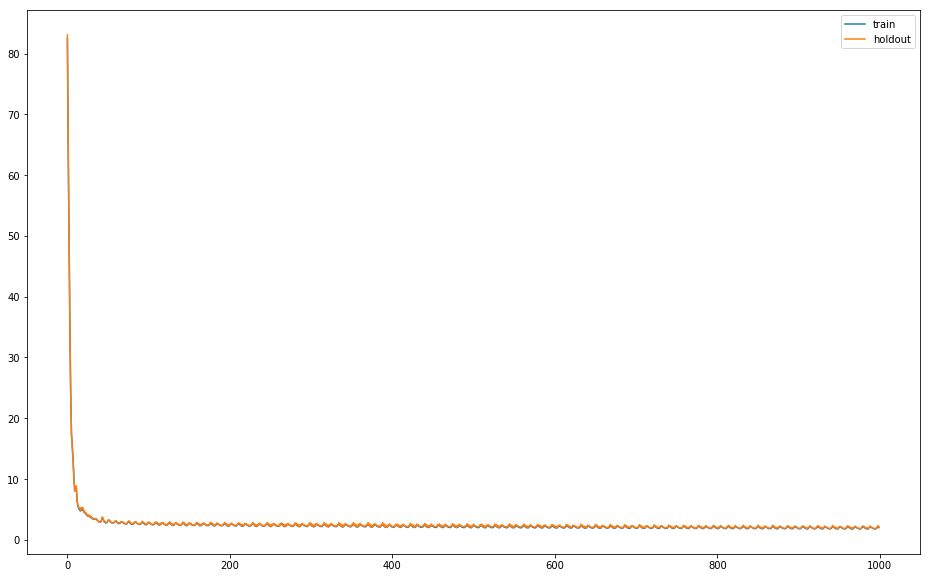

In [11]:
control.plot_losses()